In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pickle
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

df = pd.read_csv('processed_churn_data.csv')

In [2]:
X = df.drop('Churn', axis=1)
y = df['Churn']

numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print(f"Numerical: {len(numerical_features)}")
print(f"Categorical: {len(categorical_features)}")

Numerical: 4
Categorical: 15


In [3]:
X_encoded = X.copy()

label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

y_encoded = (y == 'Yes').astype(int)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_encoded, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_encoded
)

print(f"Train: {X_train.shape}")
print(f"Test: {X_test.shape}")

Train: (5634, 19)
Test: (1409, 19)


In [5]:
scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test_scaled[numerical_features] = scaler.transform(X_test[numerical_features])

In [6]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=10),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42, n_estimators=100),
    'SVM': SVC(random_state=42, probability=True),
    'K-Nearest Neighbors': KNeighborsClassifier()
}

In [7]:
results = []

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_scaled, y_train)
    
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, 'predict_proba') else None
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
    
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()
    
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc,
        'CV Mean': cv_mean,
        'CV Std': cv_std
    })

Training Logistic Regression...
Training Decision Tree...
Training Random Forest...
Training Gradient Boosting...
Training SVM...
Training K-Nearest Neighbors...


In [8]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('F1-Score', ascending=False)
print(results_df.to_string(index=False))

              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC  CV Mean   CV Std
Logistic Regression  0.799858   0.644654 0.548128  0.592486 0.840425 0.803511 0.013410
  Gradient Boosting  0.807665   0.678201 0.524064  0.591252 0.844114 0.798543 0.012838
      Random Forest  0.795600   0.643333 0.516043  0.572700 0.825276 0.789847 0.008550
                SVM  0.799858   0.669118 0.486631  0.563467 0.791312 0.797834 0.011778
      Decision Tree  0.774308   0.579096 0.548128  0.563187 0.763799 0.765705 0.011044
K-Nearest Neighbors  0.749468   0.529086 0.510695  0.519728 0.769867 0.752216 0.013881


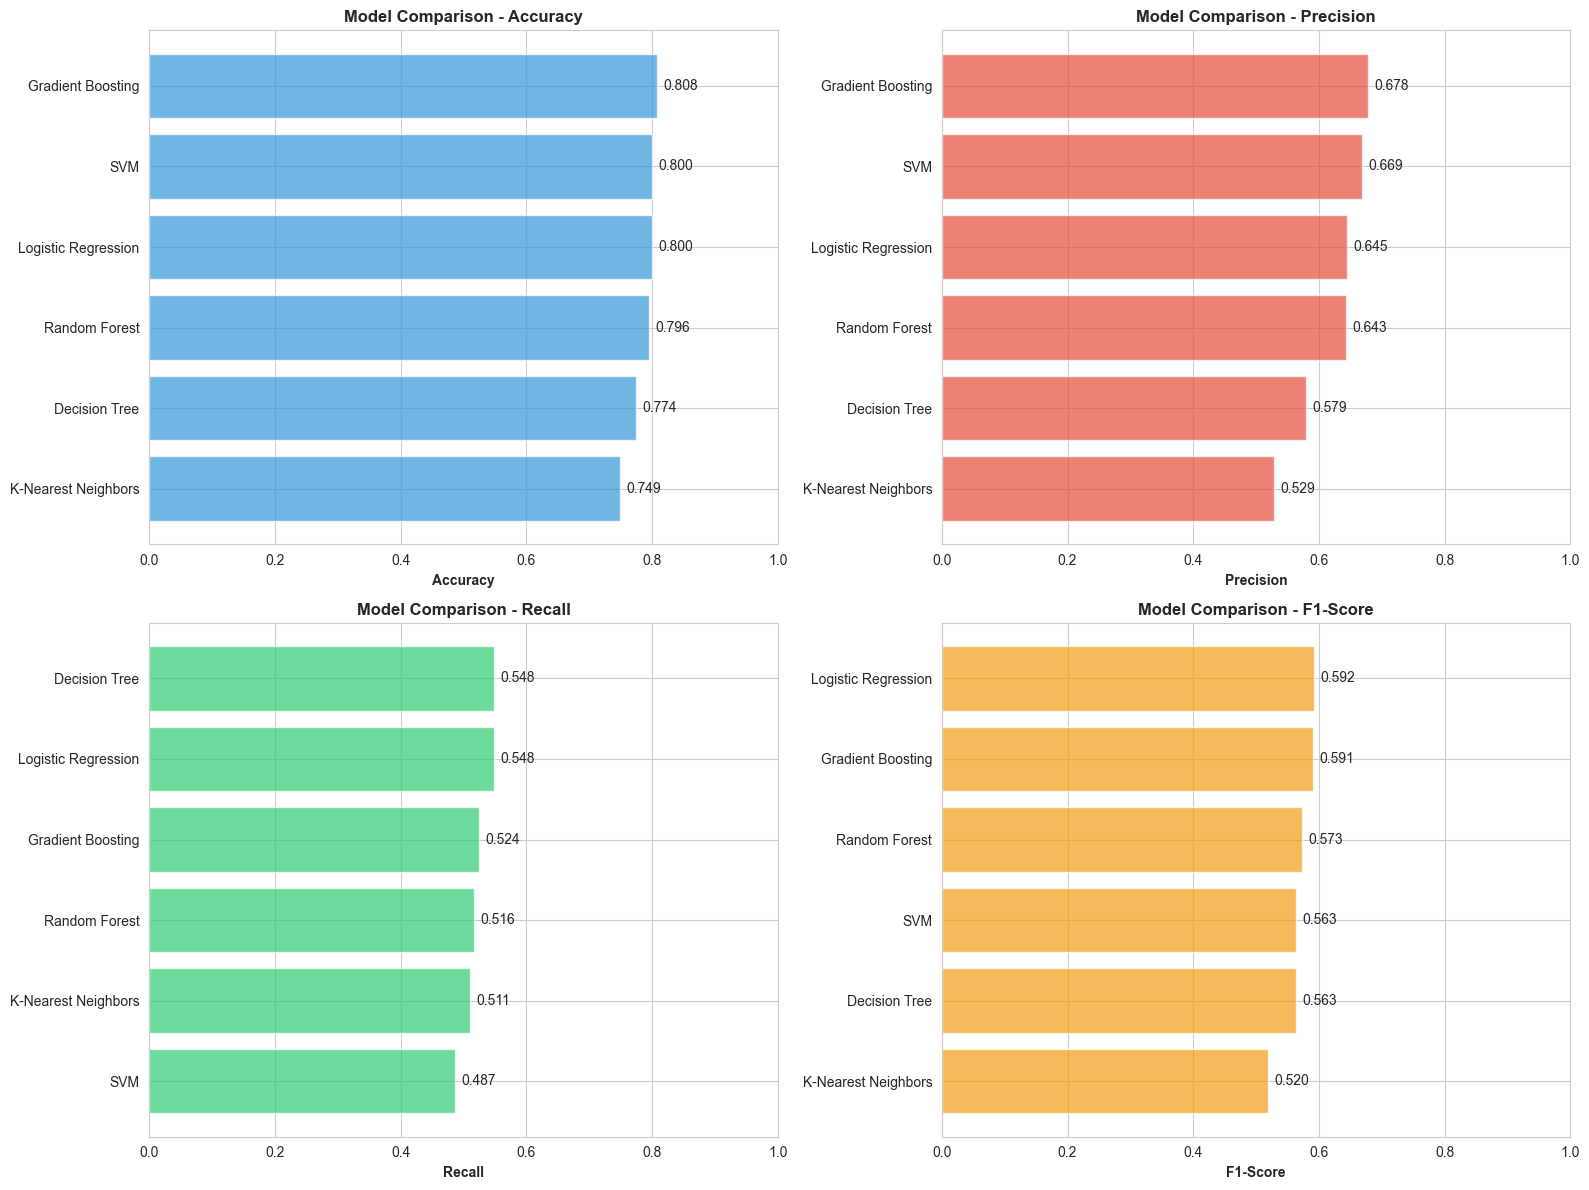

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

for idx, (metric, color) in enumerate(zip(metrics, colors)):
    ax = axes[idx // 2, idx % 2]
    data = results_df.sort_values(metric, ascending=True)
    ax.barh(data['Model'], data[metric], color=color, alpha=0.7)
    ax.set_xlabel(metric, fontweight='bold')
    ax.set_title(f'Model Comparison - {metric}', fontsize=12, fontweight='bold')
    ax.set_xlim(0, 1)
    
    for i, v in enumerate(data[metric]):
        ax.text(v + 0.01, i, f'{v:.3f}', va='center')

plt.tight_layout()
plt.show()

In [10]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', None]
}

rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(
    rf, 
    param_grid, 
    cv=5, 
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': ['balanced', None],
                         'max_depth': [10, 20, 30, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='f1', verbose=1)

In [11]:
best_model = grid_search.best_estimator_

y_pred_final = best_model.predict(X_test_scaled)
y_pred_proba_final = best_model.predict_proba(X_test_scaled)[:, 1]

final_accuracy = accuracy_score(y_test, y_pred_final)
final_precision = precision_score(y_test, y_pred_final)
final_recall = recall_score(y_test, y_pred_final)
final_f1 = f1_score(y_test, y_pred_final)
final_roc_auc = roc_auc_score(y_test, y_pred_proba_final)

print(f"Accuracy: {final_accuracy:.4f}")
print(f"Precision: {final_precision:.4f}")
print(f"Recall: {final_recall:.4f}")
print(f"F1-Score: {final_f1:.4f}")
print(f"ROC-AUC: {final_roc_auc:.4f}")

feature_importance = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Importance': best_model.feature_importances_
}).sort_values('Importance', ascending=False)

print(feature_importance.head(10).to_string(index=False))

Accuracy: 0.7686
Precision: 0.5471
Recall: 0.7460
F1-Score: 0.6312
ROC-AUC: 0.8418
         Feature  Importance
        Contract    0.193468
          tenure    0.146535
    TotalCharges    0.116909
  MonthlyCharges    0.114132
  OnlineSecurity    0.094990
     TechSupport    0.083287
 InternetService    0.048213
   PaymentMethod    0.040614
    OnlineBackup    0.029842
PaperlessBilling    0.020513


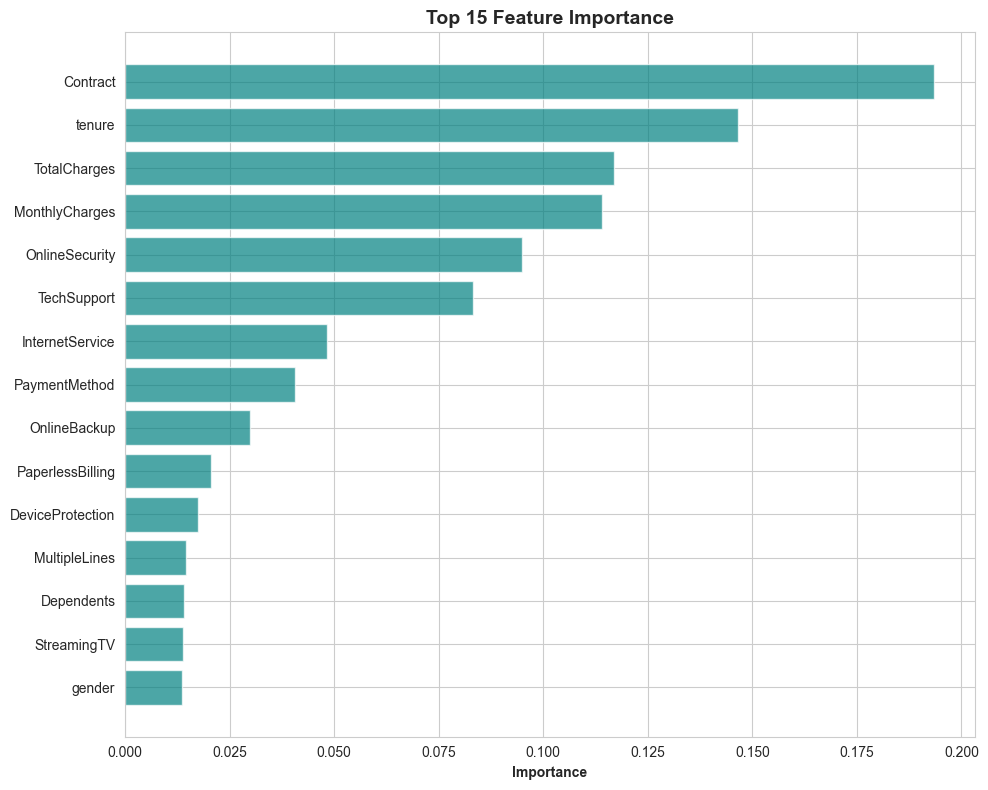

Saved!


In [12]:
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(15)
plt.barh(top_features['Feature'], top_features['Importance'], color='teal', alpha=0.7)
plt.xlabel('Importance', fontweight='bold')
plt.title('Top 15 Feature Importance', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# CELL 15: Save Models
with open('churn_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

with open('label_encoders.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)

with open('feature_names.pkl', 'wb') as f:
    pickle.dump({
        'all_features': X_encoded.columns.tolist(),
        'numerical_features': numerical_features,
        'categorical_features': categorical_features
    }, f)

results_df.to_csv('model_comparison_results.csv', index=False)

print("Saved!")